# 目标编码(Target Encoding)

**目标编码（Target Encoding）**，也称为均值编码（Mean Encoding），是一种用于将分类变量转换为数值型变量的有监督编码技术。它利用目标变量（如分类中的label、回归中的目标值）来生成类别的数值表示。

目标编码的**核心思想**是：用每个类别在训练数据中对应目标变量的平均值来表示这个类别。这种方法通过引入目标变量信息，使模型能够更好地利用类别变量中的隐藏信息，但也带来了数据泄漏和过拟合的风险。

如果某一个分类变量的取值非常多，那么称其为**高基数特征**。目标编码非常适用于高基数类别特征的编码。

## 原理介绍

### 原理公式

给定：
- 一个类别特征列$X$，如：['A', 'B', 'A', 'C'] 
- 一个目标变量$y$，如：[1, 0, 1, 1] 
目标是对类别特征$X$中的每个唯一值，计算它在$y$中对应的平均值：
$$\text{TargetEncoded}(x_i) = \frac{1}{n_i} \sum_{j=1}^{n_i} y_j \quad \text{for all } x_j = x_i$$

### 示例

#### 原始特征

| 样本 | 类别X | 标签y |
| -- | --- | --- |
| 1  | A   | 1   |
| 2  | B   | 0   |
| 3  | A   | 1   |
| 4  | C   | 1   |

#### 分类别计算均值编码
- A → (1+1)/2=1.0(1 + 1)/2 = 1.0 
- B → 0/1=0.00/1 = 0.0 
- C → 1/1=1.0/1 = 1.0 

#### 编码后结果
| 样本 | 类别X | 标签y | 编码结果 |
| -- | --- | --- | ---- |
| 1  | A   | 1   | 1.0  |
| 2  | B   | 0   | 0.0  |
| 3  | A   | 1   | 1.0  |
| 4  | C   | 1   | 1.0  |

#### 可能存在问题
- 标签泄漏: 目标编码计算均值过程中使用了标签信息，如果计算过程中不小心使用了测试集中的标签信息，会导致模型在训练时“看到未来”，也即“标签泄漏”。
- 小样本过拟合: 如果某个类别出现次数太少，它的编码值（均值）可能会非常不稳定或出现极端值。

### 解决方法：平滑 + K折编码

#### 平滑（Smoothing）

将类别的目标均值与整体均值进行加权平均：
$$\hat{y}_x = \frac{n_x \cdot \bar{y}_x + m \cdot \bar{y}}{n_x + m}$$
其中，
- $n_x$：该类别的样本数 
- $\bar{y}_x$：该类别目标均值 
- $\bar{y}$：全体目标均值 
- $m$：平滑参数，越大则更偏向全局均值 

#### K折目标编码（Cross-Validation Encoding）

- 将训练集划分为 K 折，每次用 K-1 折计算均值编码，应用在剩下的 1 折上。
- 由于在这个过程中对当前样本的编码值并不使用它自身的标签信息，因此可以避免标签泄漏。

## 优缺点

- 优点:
    - 更节省空间（避免大量 One-Hot 特征）
    - 对高基数特征更有效
    - 融合了标签信息，模型表达能力更强
- 缺点: 
    - 操作难度大，容易标签泄漏
    - 对类别少、样本少的特征不稳健
    - 不适合在测试集中直接使用训练集目标均值（需加防泄漏策略）

## 使用场景介绍

### 适用场景
- **分类变量是有序的（Ordinal）**: 目标编码能保留类别之间的“顺序”关系，而 One-Hot 编码会打乱这种顺序。
- **类别数量很多（高基数）**: 独热编码会导致维度爆炸，目标编码则能压缩为一个数值列。
- **类别与目标变量具有较强相关性**: 如果某些类别倾向于更高或更低的目标值，目标编码可以提取这种统计关系，增强特征表达能力。
- **用于不支持类别变量的模型**: 如线性回归、逻辑回归、神经网络等，需要数值输入时，目标编码是一种比 One-Hot 更压缩有效的方式。
- **作为统计特征，增强模型表达力**: 目标编码可以作为一种“标签统计信息”，在特征工程阶段加入模型，提升性能。
- **在树模型中使用（如 LightGBM、XGBoost）**: 虽然树模型可以处理类别特征，但目标编码能引入目标分布信息，提升效果。

### 慎用场景
- **类别样本数很少时**: 容易出现过拟合，编码值极端不稳定。需要引入平滑或合并小样本类别。
- **训练数据和测试数据之间存在数据泄漏风险时**: 如果不使用交叉编码（K折）或时间戳切分，模型可能“偷看答案”，训练效果很好但泛化很差。

### 不适用场景
- **类别数量很少（如性别、是/否等）**: 用 One-Hot 更清晰，不需要目标编码。
- **无监督学习任务（聚类、降维等）**: 目标编码会引入目标变量的信息，用于无监督任务属于数据泄漏。

# 代码实现

## category_encoders.TargetEncoder()

### 输入参数
- `verbose`：是否输出日志信息。
    - 0（默认）：不输出
    - 1 ：输出编码日志信息
- `cols`：指定需要进行目标编码的列名。
    - None（默认）：自动识别非数值列
    - 显式指定待编码的列
- `drop_invariant`：是否删除编码后方差为 0 的列。
    - False（默认）：保留这些列
    - True：删除无变化的列（对模型无用）
- `handle_missing`：训练或测试数据中出现缺失值（NaN）时的处理方式。
    - 'value'（推荐）：使用全局均值进行编码
    - 'return_nan'：保留 NaN 值
    - 'error'：抛出错误，适合缺失值应已清洗干净的场景
- `handle_unknown`：测试集中出现训练集中未见的类别时的处理方式。
    - 'value'（推荐）：使用全局均值
    - 'return_nan'：返回 NaN
    - 'error'：抛出错误（默认，易导致程序中断）
- `smoothing`：控制类别均值与全局均值之间的加权平滑程度。
    - 默认：10
    - 数值越大，编码结果越接近全局均值；数值越小，越贴近该类别真实均值
    - 建议范围：5 ~ 30（需要调参）

### 方法

| 方法名 / 属性名                      | 说明                                 |
| ------------------------------ | ---------------------------------- |
| `fit(X, y)`                    | 拟合目标编码器，学习每个类别对应的目标均值（必须提供 `y`）    |
| `transform(X)`                 | 使用已拟合好的编码器，将分类变量编码为数值型（无需再次传入 `y`） |
| `fit_transform(X, y)`          | 拟合并转换（适用于训练集）                      |
| `inverse_transform(X_encoded)` | 将编码后的数据还原为原始类别（注意：对目标编码并不总是精确可逆）   |
| `get_params()`                 | 获取编码器当前参数配置（以字典形式返回）               |
| `set_params(**params)`         | 设置编码器的参数                           |
| `get_feature_names_out()`      | 获取编码后的特征列名列表                       |
| `cols`                         | 需要编码的列名列表（初始化或拟合后可访问）              |
| `category_mapping`             | 存储每个类别及其编码值的映射关系（拟合后可查看）           |
| `drop_cols_`                   | 自动删除的列（如 `drop_invariant=True` 时）  |
| `feature_names_in_`            | 输入特征名称（scikit-learn >= 1.0 支持）     |


# 实际案例

## 泰坦尼克数据集

**titanic 数据集**包含了 891 条乘客记录，每条记录描述了乘客的个人信息及其在 Titanic 号上的生存情况
- survived：生存情况（0 = 未生还, 1 = 生还）
- pclass：乘客舱等级（1 = 一等舱, 2 = 二等舱, 3 = 三等舱）
- sex：乘客性别（male = 男性, female = 女性）
- age：乘客年龄（float，部分缺失值）
- sibsp：乘客在船上的兄弟姐妹或配偶数量（整数）
- parch：乘客在船上的父母或子女数量（整数）
- fare：乘客支付的票价（float）
- embarked：乘客登船港口（C = 瑟堡, Q = 皇后镇, S = 南安普敦）
- class：舱等级（文本版本的 pclass，First = 头等舱, Second = 二等舱, Third = 三等舱）
- who：乘客身份（man = 成年男性, woman = 成年女性, child = 儿童）
- adult_male：是否为成年男性（True = 是, False = 否）
- deck：乘客所在的甲板（A, B, C, D, E, F, G，部分缺失值较多）
- embark_town：乘客登船的城市（Cherbourg = 瑟堡, Queenstown = 皇后镇, Southampton = 南安普敦）
- alone：是否独自旅行（True = 独自旅行，False = 有亲属同行，对应 sibsp + parch == 0）

In [3]:
# 导入必要的库
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# 加载seaborn内置的泰坦尼克数据集
df = sns.load_dataset('titanic')

# 填充 'age' 列的缺失值：使用该列的中位数填充缺失值
df['age'].fillna(df['age'].median(), inplace=True)
# 填充 'embarked' 列的缺失值：使用该列的众数填充缺失值
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)
# 将 'sex' 列转化为数值：'male' 映射为 1，'female' 映射为 0
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
# # 将 'embarked' 列转化为数值：'C' 映射为 0，'Q' 映射为 1，'S' 映射为 2
# df['embarked'] = df['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,1,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,0,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,0,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,0,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,1,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,0,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,0,28.0,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,1,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


## 代码实现

lightgbm版本必须是4.6.0，否则可能报错

Training until validation scores don't improve for 50 rounds
[10]	train's binary_logloss: 0.570369	train's auc: 0.898699	valid's binary_logloss: 0.581838	valid's auc: 0.900515
[20]	train's binary_logloss: 0.505153	train's auc: 0.904166	valid's binary_logloss: 0.514921	valid's auc: 0.904826
[30]	train's binary_logloss: 0.461299	train's auc: 0.906901	valid's binary_logloss: 0.472729	valid's auc: 0.906821
[40]	train's binary_logloss: 0.430817	train's auc: 0.910452	valid's binary_logloss: 0.445246	valid's auc: 0.907658
[50]	train's binary_logloss: 0.408863	train's auc: 0.914704	valid's binary_logloss: 0.428529	valid's auc: 0.906885
[60]	train's binary_logloss: 0.390157	train's auc: 0.918721	valid's binary_logloss: 0.419571	valid's auc: 0.905856
[70]	train's binary_logloss: 0.374392	train's auc: 0.922457	valid's binary_logloss: 0.411673	valid's auc: 0.904247
[80]	train's binary_logloss: 0.36162	train's auc: 0.926772	valid's binary_logloss: 0.404982	valid's auc: 0.906049
Early stopping, best

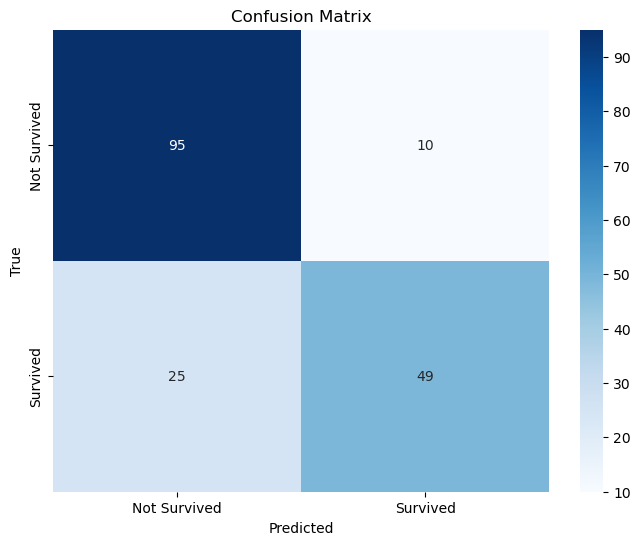

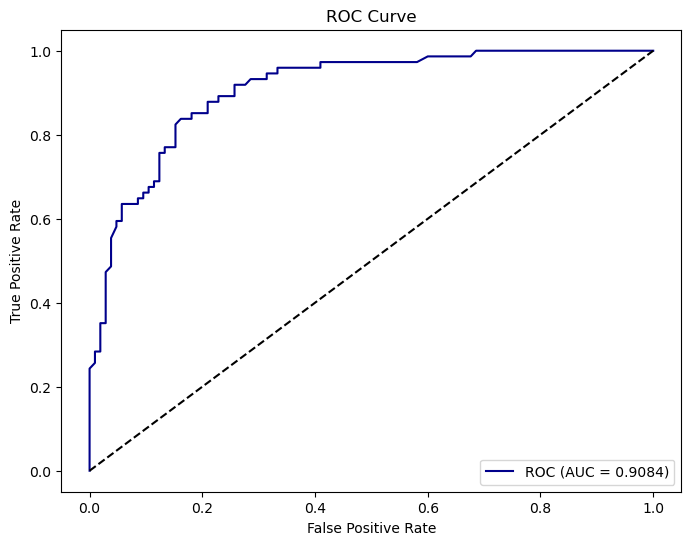

In [4]:
# ============ 1. 导入必要的库 ============
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import category_encoders as ce  # 用于目标编码

# ============ 2. 选择特征和目标变量 ============
# 假设 df 是已加载并预处理好的泰坦尼克号数据
# 特征包含类别型和数值型变量
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
target = 'survived'

# 去除包含缺失值的行，确保训练集干净
df = df[features + [target]].dropna()

# 拆分特征与目标
X = df[features]
y = df[target]

# ============ 3. 划分训练集与验证集 ============
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============ 4. 对类别变量使用 KFold Target Encoding ============
cat_cols = ['embarked']  # 要进行目标编码的类别特征
X_train_encoded = X_train_raw.copy()
X_test_encoded = X_test_raw.copy()

# 创建 5 折交叉验证器
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 针对每个类别变量执行 KFold 编码
for col in cat_cols:
    # 初始化一个新的列，用于存放训练集编码后的值
    X_train_encoded[col + '_te'] = np.nan

    # 对每一折进行编码训练与验证
    for train_idx, val_idx in kf.split(X_train_raw):
        # 获取当前折的训练集和验证集
        X_train_fold = X_train_raw.iloc[train_idx]
        X_val_fold = X_train_raw.iloc[val_idx]
        y_train_fold = y_train.iloc[train_idx]

        # 用当前折训练数据拟合编码器
        encoder = ce.TargetEncoder(cols=[col])
        encoder.fit(X_train_fold[col], y_train_fold)

        # 用训练好编码器对验证集编码（注意：不能使用验证集 fit，避免信息泄露）
        X_train_encoded.loc[X_train_encoded.index[val_idx], col + '_te'] = encoder.transform(X_val_fold[col])[col]

    # 对验证集编码，使用整个训练集重新拟合编码器
    encoder = ce.TargetEncoder(cols=[col])
    encoder.fit(X_train_raw[col], y_train)
    X_test_encoded[col + '_te'] = encoder.transform(X_test_raw[col])[col]

# 删除原始的类别变量列，只保留编码后的数值列
X_train_encoded.drop(columns=cat_cols, inplace=True)
X_test_encoded.drop(columns=cat_cols, inplace=True)

# ============ 5. 数值特征与目标编码列拼接 ============
# 其余数值特征（包含 sex，已是二值）
num_cols = ['sex', 'pclass', 'age', 'sibsp', 'parch', 'fare']
# 拼接所有最终使用的特征
X_train_final = pd.concat(
    [X_train_encoded[num_cols], X_train_encoded[[col + '_te' for col in cat_cols]]], axis=1
)
X_test_final = pd.concat(
    [X_test_encoded[num_cols], X_test_encoded[[col + '_te' for col in cat_cols]]], axis=1
)

# 转换为 NumPy 数组供 LightGBM 使用
X_train = X_train_final.to_numpy()
X_test = X_test_final.to_numpy()
feature_names = X_train_final.columns.tolist()  # 保存特征名用于展示

# ============ 6. LightGBM 数据集构建 ============
dtrain = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
dtest = lgb.Dataset(X_test, label=y_test, reference=dtrain)

# ============ 7. LightGBM 模型参数设置 ============
params = {
    'objective': 'binary',                    # 二分类任务
    'metric': {'binary_logloss', 'auc'},     # 使用 Logloss 和 AUC 作为评估指标
    'num_leaves': 60,                        # 叶子节点数
    'max_depth': -1,                         # 不限制深度
    'min_data_in_leaf': 30,                  # 一个叶子上最小样本数
    'learning_rate': 0.03,                   # 学习率
    'feature_fraction': 0.9,                 # 每次迭代随机选择的特征比例
    'bagging_fraction': 0.8,                 # 每次迭代随机选择的样本比例
    'lambda_l1': 0.1,                        # L1 正则项
    'lambda_l2': 0.001,                      # L2 正则项
    'verbosity': -1,                         # 不打印日志
    'seed': 2019                             # 随机种子，确保复现
}

# ============ 8. 模型训练 ============
model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dtest],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(50),             # 如果 50 轮无提升，提前停止
        lgb.log_evaluation(10)              # 每 10 轮输出一次日志
    ]
)

# ============ 9. 模型预测 ============
# 输出测试集中每个样本的预测概率
y_probs = model.predict(X_test)
# 将概率转为 0-1 标签，阈值为 0.5
y_pred = (y_probs > 0.5).astype(int)

# ============ 10. 模型评估 ============
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ============ 11. 可视化结果 ============

# (1) 混淆矩阵可视化
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Survived", "Survived"],
    yticklabels=["Not Survived", "Survived"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# (2) ROC 曲线与 AUC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkblue', label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # 虚线表示随机预测的 ROC 曲线
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()